In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, random_split, Subset

from sklearn.preprocessing import MinMaxScaler

import os
import argparse

from util.env import get_device, set_device
from util.preprocess import build_loc_net, construct_data
from util.net_struct import get_feature_map, get_fc_graph_struc
from util.iostream import printsep

from datasets.TimeDataset import TimeDataset


from models.GDN import GDN

/home/jiin/anaconda3/envs/gdn/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from evaluate import *
from train import train
from test  import test

In [21]:
random_seed = 5
dataset = 'IP_terminal'

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(random_seed)

train_config = {
        'batch': 32,
        'epoch': 30,
        'slide_win': 5,
        'dim': 64,
        'slide_stride': 1,
        'comment': dataset,
        'seed': 5,
        'out_layer_num': 1,
        'out_layer_inter_dim': 128,
        'decay': 0,
        'val_ratio': 0.2,
        'topk': 1,
    }

env_config={
        'save_path': dataset,
        'dataset': dataset,
        'report': 'best',
        'device': 1,
        'load_model_path': ''
    }

In [22]:
from main import Main

In [23]:
main = Main(train_config=train_config, env_config=env_config)

In [24]:
model_save_path = './pretrained/IP_terminal/best_05|08-02:29:33.pt'
    

main.model.load_state_dict(torch.load(model_save_path))
best_model = main.model.to(main.device)

In [26]:
_, test_result = test(best_model, main.test_dataloader)
_, val_result = test(best_model, main.val_dataloader)

# main.get_score(test_result, val_result)

In [27]:
final_err_scores = get_final_err_scores(test_result, val_result )

In [38]:
full_scores, all_normals = get_full_err_scores(test_result, val_result)#, return_normal_scores=True)

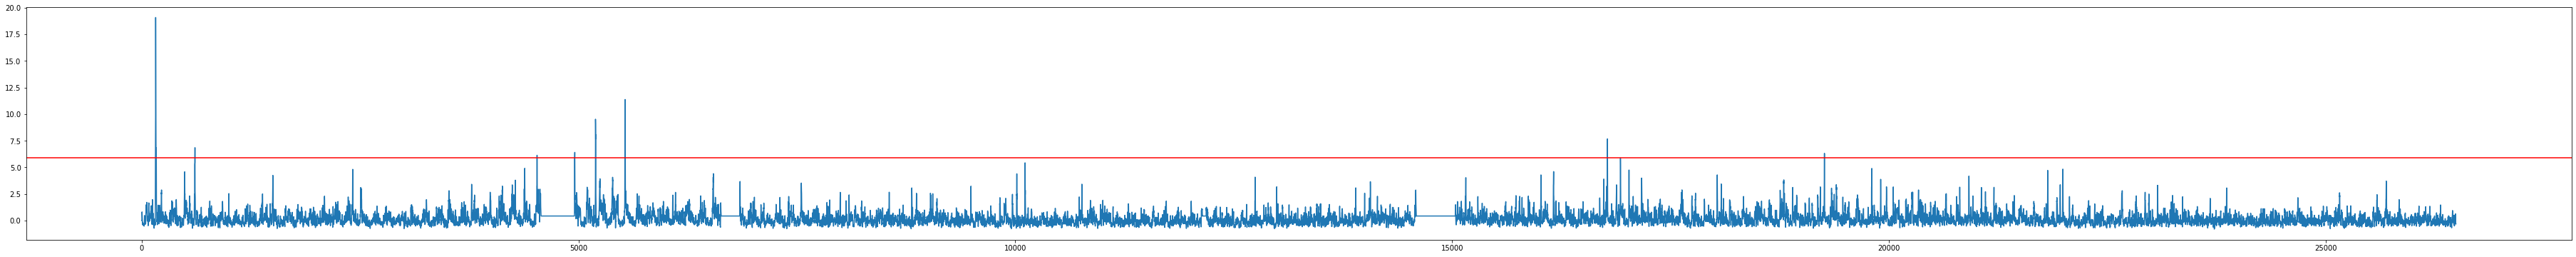

In [45]:
plt.figure(figsize=(64, 6))
plt.plot(full_scores)
plt.axhline(np.quantile(full_scores, q=0.999), color='r')
# plt.ylim(0, 20)

In [51]:
def preprocess_data():
    # 학습 데이터 읽기. 경로 설정에 주의 하세요!
    data = pd.read_csv('../dataset/data/IP/DHCP.csv')
    print(f'전체 데이터 세트. \n{data}\n')

    # TODO: 예시코드 실행을 위한 Train_set/Test_set 분할입니다. 반드시 이 형태로 학습/테스트할 필요는 없습니다.
    idx_half = data.index[data['Timestamp'] == '20210630_2350-0000'].tolist()[0]
    train_set = data[:idx_half+1]  # 1.1 - 6.30 분리
    test_set = data[idx_half+1:]   # 7.1 - 12.31 분리

#     print(f'1월-6월. \n{train_set}\n')
#     print(f'7월-12월. \n{test_set}\n')

    # -----------------------------------
    # TODO: 데이터 분석을 통해 다양한 전처리를 시도 해보세요!
    preprocessed_train_set = train_set





    # -----------------------------------

    return preprocessed_train_set, test_set

def save_pred(predict, test_data):
    # TODO: 모델을 활용해, 2021년 하반기 전체에 대한 예측을 수행하세요!
#     pred = model(test_data)

    # 예측된 결과를 제출하기 위한 포맷팅
    answer = pd.DataFrame(predict, columns=['Prediction'])
    print(f'예측 결과. \n{answer}\n')  # TODO: 제출 전 row size "29496" 확인
    answer.to_csv('../IP_terminal_answer.csv', index=False)  # 제출용 정답지 저장

# TODO: 제출 파일은 2021년 7월 1일 00시 00분-10분 부터 2021년 12월 31일 23시 50분-00분 구간의 이상 이벤트를 예측한
#  .csv 형식으로 저장해야 합니다.
#  예측 데이터프레임의 크기는 [26496 * 1]입니다.

In [47]:
train_data, test_data = preprocess_data()

전체 데이터 세트. 
                Timestamp  Svr_detect  Svr_connect  Ss_request  Ss_Established
0      20210101_0000-0010         0.0          0.0         5.0             8.0
1      20210101_0010-0020         0.0          0.0         4.0            14.0
2      20210101_0020-0030         0.0          0.0         1.0            10.0
3      20210101_0030-0040         0.0          0.0         1.0            14.0
4      20210101_0040-0050         0.0          0.0         2.0             9.0
...                   ...         ...          ...         ...             ...
52555  20211231_2310-2320         0.0          2.0         5.0            15.0
52556  20211231_2320-2330         0.0          4.0         4.0            15.0
52557  20211231_2330-2340         0.0          2.0         3.0            14.0
52558  20211231_2340-2350         0.0          3.0         2.0            12.0
52559  20211231_2350-0000         0.0          2.0         3.0            16.0

[52560 rows x 5 columns]



In [48]:
threshold = np.quantile(full_scores, q=0.999)
predict = [1 if full_scores[i] > threshold else 0 for i in range(len(full_scores))]
for i in range(main.train_config['slide_win']):
    predict.insert(0, 0)
predict = np.array(predict)

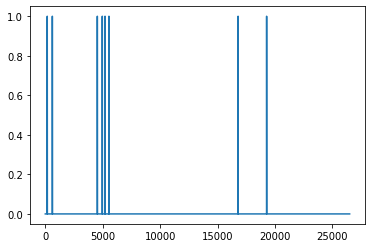

In [49]:
plt.plot(predict)

In [52]:
save_pred(predict, test_data)

예측 결과. 
       Prediction
0               0
1               0
2               0
3               0
4               0
...           ...
26491           0
26492           0
26493           0
26494           0
26495           0

[26496 rows x 1 columns]



In [53]:
server_out = pd.read_csv('../IP_server_answer.csv')
terminal_out = pd.read_csv('../IP_terminal_answer.csv')

In [59]:
out = server_out.values | terminal_out.values

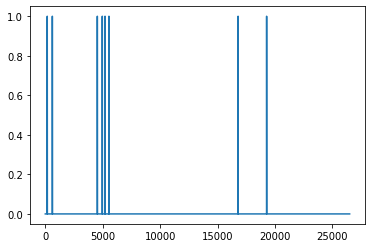

In [62]:
plt.plot(terminal_out)

In [63]:
answer = pd.DataFrame(out, columns=['Prediction'])
print(f'예측 결과. \n{answer}\n')  # TODO: 제출 전 row size "29496" 확인
answer.to_csv('../IP_answer.csv', index=False)  # 제출용 정답지 저장


예측 결과. 
       Prediction
0               0
1               0
2               0
3               0
4               0
...           ...
26491           0
26492           0
26493           0
26494           0
26495           0

[26496 rows x 1 columns]

